In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
print(os.getcwd())

/Users/aneeshussain/Code/diss/analysis


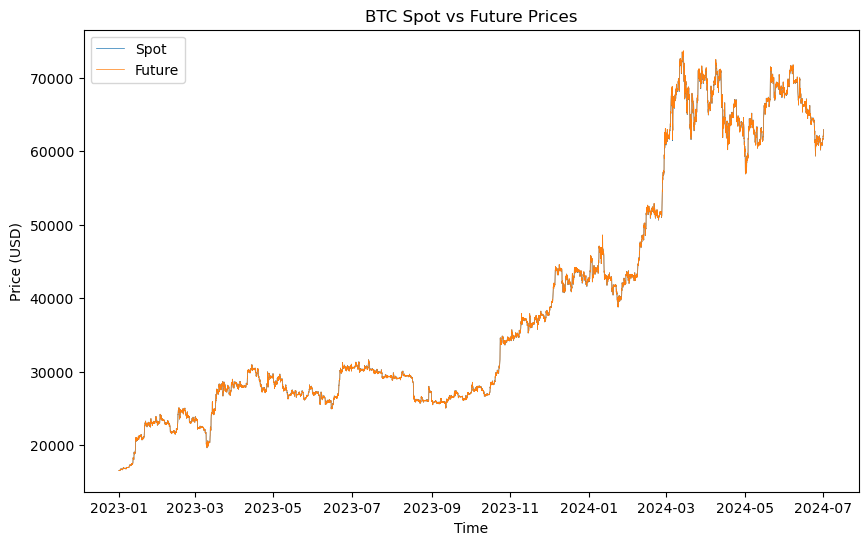

In [30]:
df = pd.read_csv('/Users/aneeshussain/Code/diss/data/processed/Binance_BTC_Prices.csv')

# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['BTCUSDT Spot'], label='Spot', linewidth=0.5)
plt.plot(df['Time'], df['BTCUSDT USDM'], label='Future', linewidth=0.5)
# Adding titles and labels
plt.title('BTC Spot vs Future Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

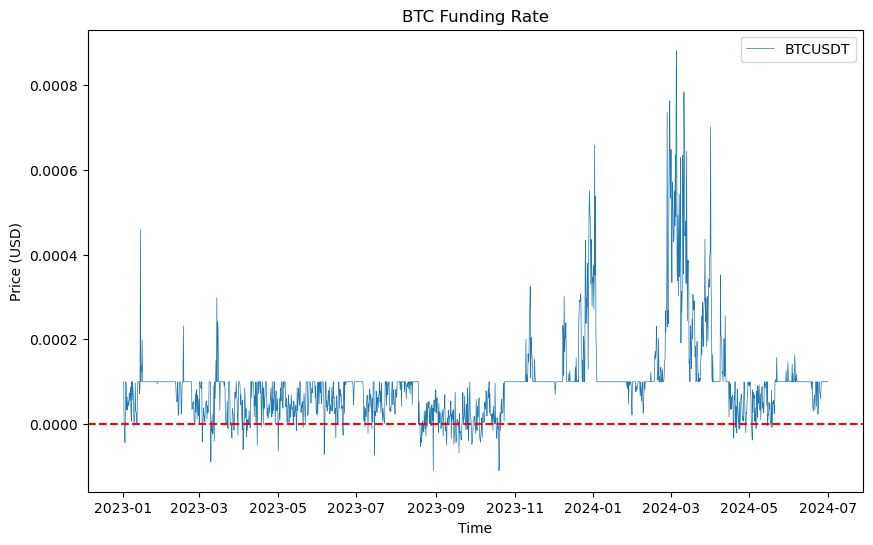

Number of positive basis values: 1454
Number of negative basis values: 188


In [31]:
df1 = pd.read_csv('/Users/aneeshussain/Code/diss/data/processed/Binance_BTCUSDT_Funding_Rate.csv')

df1['Time'] = pd.to_datetime(df1['Time'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df1['Time'], df1['Funding Rate'], label='BTCUSDT', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--')
# Adding titles and labels
plt.title('BTC Funding Rate')
plt.xlabel('Time')
plt.ylabel('Price (USD)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

# Count the number of positive and negative basis values
positive_basis_count = (df1['Funding Rate'] > 0.00001).sum()
negative_basis_count = (df1['Funding Rate'] < 0.00001).sum()

# Print the counts
print(f"Number of positive basis values: {positive_basis_count}")
print(f"Number of negative basis values: {negative_basis_count}")

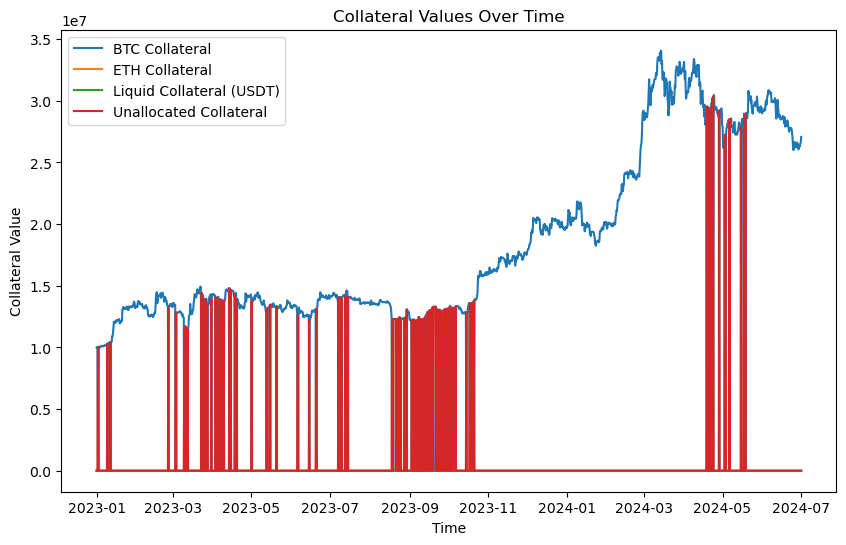

In [6]:
df_collateral = pd.read_csv('/Users/aneeshussain/Code/diss/collateral_values_log.csv')

df_collateral['time'] = pd.to_datetime(df_collateral['time'])

# Set the 'time' column as the index for easier plotting
df_collateral.set_index('time', inplace=True)

# Plot the collateral values
plt.figure(figsize=(10, 6))

# Plot each collateral type
plt.plot(df_collateral.index, df_collateral['btc_collateral'], label='BTC Collateral')
plt.plot(df_collateral.index, df_collateral['eth_collateral'], label='ETH Collateral')
plt.plot(df_collateral.index, df_collateral['liquid_collateral'], label='Liquid Collateral (USDT)')
plt.plot(df_collateral.index, df_collateral['unallocated_collateral'], label='Unallocated Collateral')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Collateral Value')
plt.title('Collateral Values Over Time')
plt.legend()

# Show the plot
plt.show()

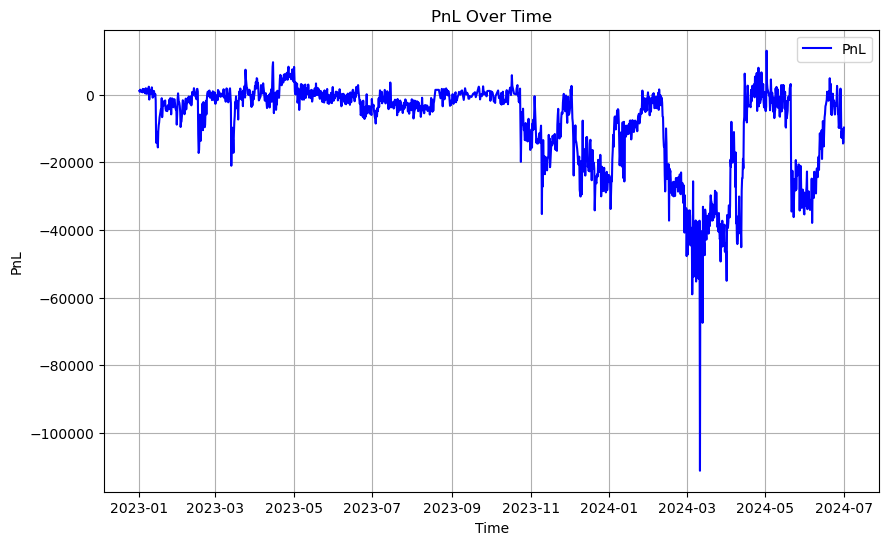

In [7]:
df_pnl = pd.read_csv('/Users/aneeshussain/Code/diss/funding_payments_log.csv')

# Convert the 'time' column to datetime format for better plotting
df_pnl['time'] = pd.to_datetime(df_pnl['time'])

# Plot the PnL values over time
plt.figure(figsize=(10, 6))
plt.plot(df_pnl['time'], df_pnl['pnl'], label='PnL', color='blue')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('PnL Over Time')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

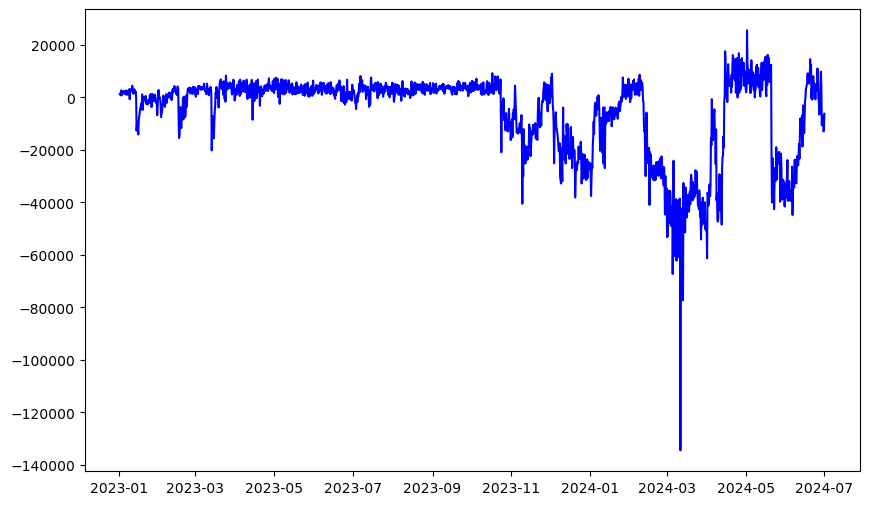

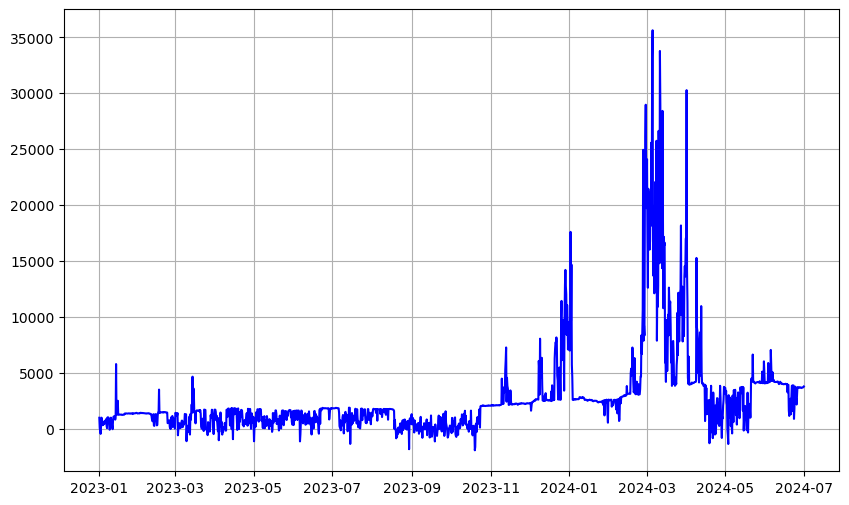

In [10]:
df_fr = pd.read_csv('/Users/aneeshussain/Code/diss/data/raw/funding_payments_log.csv')

# Convert the 'time' column to datetime format for better plotting
df_fr['time'] = pd.to_datetime(df_fr['time'])

# Plot the PnL values over time
plt.figure(figsize=(10, 6))
plt.plot(df_fr['time'], df_fr['pnl'], label='PnL', color='blue')


plt.figure(figsize=(10, 6))
plt.plot(df_fr['time'], df_fr['funding payment'], label='funding', color='blue')

# # Add labels and title
# plt.xlabel('Time')
# plt.ylabel('PnL')
# plt.title('PnL Over Time')
# plt.legend()

# Display the plot
plt.grid(True)
plt.show()